In [ ]:
from ai_models_fourcastnetv2 import model as sfno
import cfgrib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
# Path to your GRIB file
grib_file = "sfno_stuff/florence.grib"

# Load the GRIB file using xarray
ds = xr.open_dataset(
    grib_file, 
    engine='cfgrib', 
    filter_by_keys={'shortName': 'msl'}
)

'''
The ordering of atmospheric variables along the channel dimension is as follows:
'''
variables = ['u10',
             'v10',
             't2m',
             'sp',
             'msl',
             't850',
             'u1000',
             'v1000',
             'z1000',
             'u850',
             'v850',
             'z850',
             'u500',
             'v500',
             'z500',
             't500',
             'z50' ,
             'r500',
             'r850',
             'tcwv']


In [ ]:
import h5py

x_min = 1080
x_max = 1160
y_min = 200
y_max = 240

field = 'msl' 

pred_msl = ds['msl'].values

ic = 1020
dt = 1
prediction_length = 15

data_path = "/home/jovyan/shared/fourcastnet/FourCastNet/data/FCN_ERA5_data_v0/out_of_sample"
data_file = os.path.join(data_path, "2018.h5")
data = h5py.File(data_file, 'r')['fields'][ic:(ic+prediction_length*dt):dt,[i for i in range(20)],0:720, 0:1440]

msl_heatmap = h5py.File(data_file, 'r')['fields'][ic+6*10][4][y_min:y_max, x_min:x_max]

true_msl = data[:, 4]

print(pred_msl.shape)
print(true_msl.shape)



(41, 721, 1440)
(15, 720, 1440)


In [ ]:
seventeen_small_rows = true_msl[:, y_min:y_max, x_min:x_max]
seventeen_big_rows = true_msl[:, :, :]


track_pred_x = []
track_pred_y = []
track_true_x = []
track_true_y = []
    
for idx, i in enumerate(seventeen_small_rows):
    min_pressure_true = np.min(true_msl[idx, y_min:y_max, x_min:x_max])
    true_y = np.where(i == min_pressure_true)[0]
    true_x = np.where(i == min_pressure_true)[1]
    track_true_x.append(true_x[0] + x_min)
    track_true_y.append(true_y[0] + y_min)
    
    # Predicted values
    min_pressure_predicted = np.min(pred_msl[idx,y_min:y_max,x_min:x_max])
    pred_y = np.where(pred_msl[idx,y_min:y_max, x_min:x_max] == min_pressure_predicted)[0]
    pred_x = np.where(pred_msl[idx,y_min:y_max, x_min:x_max] == min_pressure_predicted)[1]
    track_pred_x.append(pred_x[0] + x_min)
    track_pred_y.append(pred_y[0] + y_min)
    
def index_to_lon(x):
    return x/4-360

def index_to_lat(y):
    return 90 - y/4

y_func = np.vectorize(index_to_lat)
x_func = np.vectorize(index_to_lon)

track_true_y = y_func(track_true_y)
track_true_x = x_func(track_true_x)

track_pred_y = y_func(track_pred_y)
track_pred_x = x_func(track_pred_x)

(41, 721, 1440)
(15, 720, 1440)
[1148, 1143, 1140, 1137, 1134, 1132, 1130, 1128, 1126, 1124, 1122, 1120, 1118, 1116, 1113]
[1148, 1143, 1139, 1136, 1134, 1132, 1130, 1128, 1125, 1123, 1122, 1120, 1119, 1116, 1114]


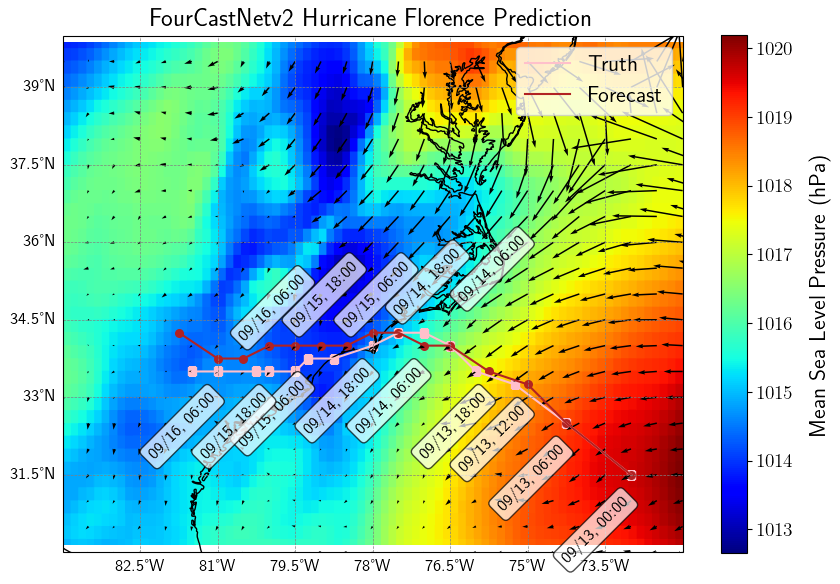

0


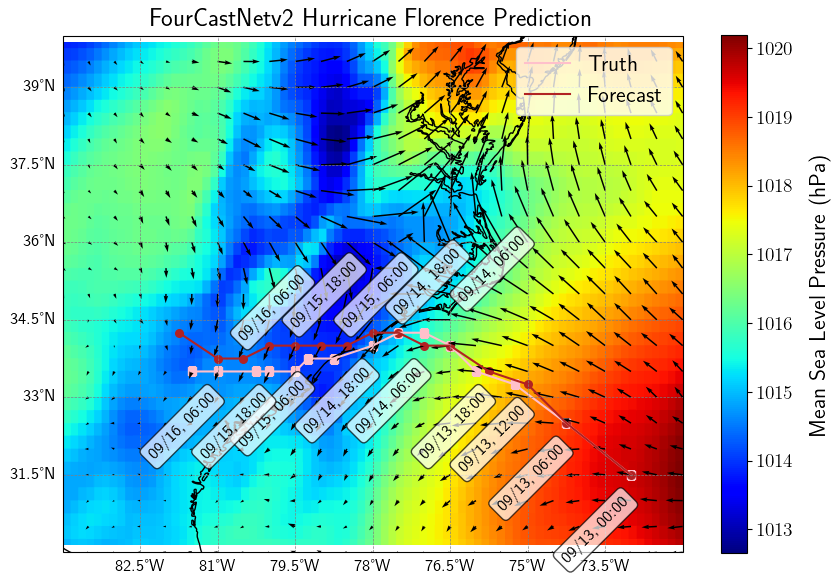

1


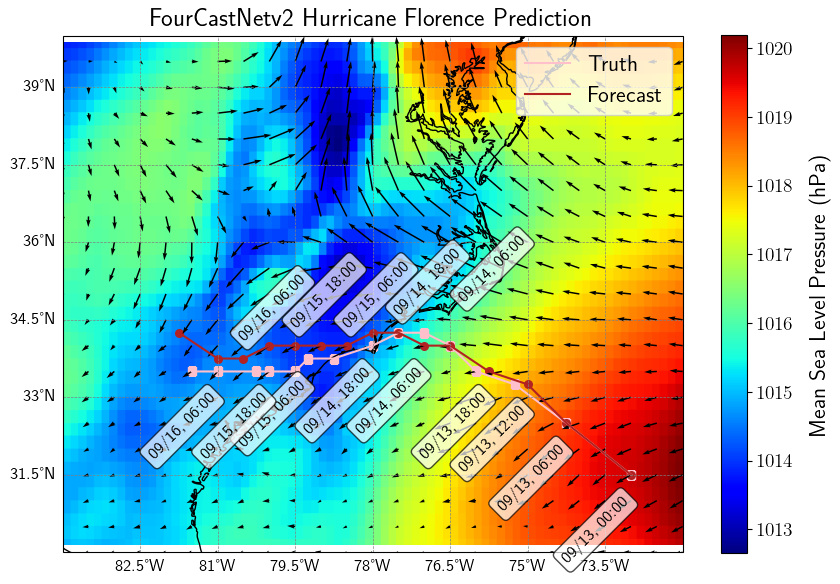

2


In [ ]:
from datetime import datetime, timedelta

central_longitude = 180
projection = ccrs.PlateCarree(central_longitude=central_longitude)
dttme = datetime(2023, 9, 13, 0, 0)

for j in range(prediction_length)[:3]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 12), subplot_kw={'projection': projection})
    
    # nc_extent = [-90, -70, 25, 45]  # [lon_min, lon_max, lat_min, lat_max]
    nc_extent = [-84, -72, 30, 40]
    ax.set_extent(nc_extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    img = ax.imshow(msl_heatmap/100, cmap='jet', extent=nc_extent, transform=ccrs.PlateCarree())
    # Create the colorbar with the same height as the figure
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', shrink=.56)
    cbar.set_label("Mean Sea Level Pressure (hPa)", fontsize=16, labelpad=10)


    
    plt.scatter(np.array(track_true_x), np.array(track_true_y), s=30, marker='s', c='pink', transform=ccrs.PlateCarree())
    plt.plot(np.array(track_true_x), np.array(track_true_y), c='pink', label="Truth", transform=ccrs.PlateCarree())
    plt.scatter(np.array(track_pred_x), np.array(track_pred_y), s=30, marker='o', c='firebrick', transform=ccrs.PlateCarree())
    plt.plot(np.array(track_pred_x), np.array(track_pred_y), c='firebrick', label="Forecast", transform=ccrs.PlateCarree())
    plt.legend(fontsize=16)

    for x1, y1, x2, y2, i in zip(track_true_x, track_true_y, track_pred_x, track_pred_y, range(0, prediction_length)):
        timestamp = dttme + timedelta(hours=6 * i)
        time_label = timestamp.strftime('%m/%d, %H:00')  # Only display day and hour
        text_props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.7)

        if i < 4:
            ax.text(x2 - 1.4, y2 - 1.7, time_label, transform=ccrs.PlateCarree(),
                    fontsize=12, color='black', rotation=45, bbox=text_props)
        elif y1 > y2 and i % 2 == 1:
            ax.text(x1 + .6, y1 + .6, time_label, transform=ccrs.PlateCarree(),
                    fontsize=12, color='black', rotation=45, bbox=text_props)
            ax.text(x2 - 1.4, y2 - 1.7, time_label, transform=ccrs.PlateCarree(),
                    fontsize=12, color='black', rotation=45, bbox=text_props)
        elif i % 2 == 1:
            ax.text(x1 - 1.4, y1 - 1.7, time_label, transform=ccrs.PlateCarree(),
                    fontsize=12, color='black', rotation=45, bbox=text_props)
            ax.text(x2 + .35, y2 + .35, time_label, transform=ccrs.PlateCarree(),
                    fontsize=12, color='black', rotation=45, bbox=text_props)
    
    field = 'u10' 
    u10 = variables.index(field)
    
    u10_heatmap = h5py.File(data_file, 'r')['fields'][ic + 6 * j][u10][y_min:y_max, x_min:x_max]
    
    field = 'v10' 
    v10 = variables.index(field)
    
    v10_heatmap = h5py.File(data_file, 'r')['fields'][ic + 6 * j][v10][y_min:y_max, x_min:x_max]
    X = np.arange(-90, -70, .5)
    Y = np.arange(30, 40, .5)
    U = u10_heatmap[::2, ::2]
    V = v10_heatmap[::2, ::2]
    
    q = plt.quiver(X, Y, U, V, transform=ccrs.PlateCarree())

    # Add lat/lon gridlines
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color='gray')
    
    # Customize gridline labels
    gl.top_labels = False   # Hide top labels
    gl.right_labels = False # Hide right labels
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.set_title('FourCastNetv2 Hurricane Florence Prediction', fontsize=18)
    plt.savefig(f'/home/jovyan/hurricane_images/fcn2_im00{j}.png')
    plt.show()
